In [1]:
import jsonlines
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from scicite.compute_features import get_formulaic_features, get_agent_features

/home/dmitry/cit_func/lib/python3.8/site-packages/allennlp/service/predictors/__init__.py:22: FutureWarning: allennlp.service.predictors.* has been depreciated. Please use allennlp.predictors.*
  warnings.warn("allennlp.service.predictors.* has been depreciated. "
/home/dmitry/cit_func/lib/python3.8/site-packages/allennlp/service/predictors/predictor.py:5: FutureWarning: allennlp.service.predictors.* has been deprecated. Please use allennlp.predictors.*
  warnings.warn("allennlp.service.predictors.* has been deprecated."


In [2]:
FILE_TEST_PRED = "[TEST]_pred_weights.jsonl"
FILE_TEST_PRED_ONLY_BERT = "pred_test_with_bert.jsonl"
FILE_TEST_TRUE = "scicite/data/acl-arc/test.jsonl"

FILE_DEV_PRED = "[DEV]_pred_weights.jsonl"
FILE_DEV_PRED_ONLY_BERT = "pred_dev_with_bert.jsonl"
FILE_DEV_TRUE = "scicite/data/acl-arc/dev.jsonl"

FILE_TRAIN_PRED = "[TRAIN]_pred_weights.jsonl"
FILE_TRAIN_PRED_ONLY_BERT = "pred_train_with_bert.jsonl"
FILE_TRAIN_TRUE = "scicite/data/acl-arc/train.jsonl"

CLASSES = ['Background', 'Uses', 'CompareOrContrast', 'Motivation', 'Extends', 'Future']

In [3]:
def compute_all_patterns_features(item):
    formulaic_features, fn_1, __ = get_formulaic_features(item['sents_before'][0], prefix='InCitSent:')
    agent_features, fn_2, _ = get_agent_features(item['sents_before'][0], prefix='InCitSent:')
    fn_3, fn_4 = [], []
    
    formulaic_clause_features = formulaic_features
    agent_clause_features = agent_features
    if len(item['sents_before']) > 1:
        for cur_sentence in item['sents_before'][1:]:
            _formulaic_features, fn_3, _ = get_formulaic_features(cur_sentence, prefix='InClause:')
            _agent_features, fn_4, _ = get_agent_features(cur_sentence, prefix='InClause:')
            formulaic_clause_features = [f_1 or f_2 for f_1, f_2 in zip(formulaic_clause_features,
                                                                        _formulaic_features)]
            agent_clause_features = [f_1 or f_2 for f_1, f_2 in zip(agent_clause_features,
                                                                    _agent_features)]
    for cur_sentence in item['sents_after']:
        _formulaic_features, _, _ = get_formulaic_features(cur_sentence, prefix='InClause:')
        _agent_features, _, _ = get_agent_features(cur_sentence, prefix='InClause:')
        formulaic_clause_features = [f_1 or f_2 for f_1, f_2 in zip(formulaic_clause_features,
                                                                    _formulaic_features)]
        agent_clause_features = [f_1 or f_2 for f_1, f_2 in zip(agent_clause_features,
                                                                _agent_features)]
        

    x = formulaic_features + agent_features + formulaic_clause_features + agent_clause_features 
    y = CLASSES.index(item['intent'])
    feature_names = fn_1 + fn_2
    if fn_3:
        feature_names += fn_3 + fn_4 
    return x, y, feature_names

In [4]:
def get_true_examples_patterns(true_file, pred_file):
    patterns_distr = {cls: [] for cls in CLASSES}
    probs_distr = {cls: [] for cls in CLASSES}
    
    # true values
    true = dict()
    with jsonlines.open(true_file) as reader:
        for obj in reader:
            true[obj['citation_id']] = obj
    
    # pred values
    pairs = dict()
    with jsonlines.open(pred_file) as reader:
        for obj in reader:
            if true[obj['citation_id']]['intent'] == obj['prediction']:
                cur_patterns, _, _ = compute_all_patterns_features(true[obj['citation_id']])
                cur_patterns = list(map(int, cur_patterns))
                patterns_distr[obj['prediction']].append(cur_patterns)
                probs_distr[obj['prediction']].append(obj['probabilities'])
    
    return patterns_distr, probs_distr

In [5]:
def get_errors(true_file, pred_file):
    result = []
    
    # true values
    true = dict()
    with jsonlines.open(true_file) as reader:
        for obj in reader:
            true[obj['citation_id']] = obj
    
    # pred values
    pairs = dict()
    with jsonlines.open(pred_file) as reader:
        for obj in reader:
            if true[obj['citation_id']]['intent'] != obj['prediction']:
                new_obj = true[obj['citation_id']]
                new_obj['prediction'] = obj['prediction']
                new_obj['probabilities'] = obj['probabilities']
                result.append(new_obj)
    
    return result

In [6]:
patterns_distr_test, probs_distr_test = get_true_examples_patterns(FILE_TEST_TRUE, FILE_TEST_PRED)

In [7]:
patterns_distr_dev, probs_distr_dev = get_true_examples_patterns(FILE_DEV_TRUE, FILE_DEV_PRED)

In [8]:
patterns_distr_train, probs_distr_train = get_true_examples_patterns(FILE_TRAIN_TRUE, FILE_TRAIN_PRED)

In [9]:
errors_test = get_errors(FILE_TEST_TRUE, FILE_TEST_PRED)

In [10]:
errors_dev = get_errors(FILE_DEV_TRUE, FILE_DEV_PRED)

***Analize***

1.   Errors' texts

In [11]:
for _ in errors_test:
    print(f"True = {_['intent']} Predict = {_['prediction']}")
    print(f"{_['text']}\n")

True = Uses Predict = Future
However , the method we are currently using in the ATIS domain ( Seneff et al. 1991 ) represents our most promising approach to this problem .

True = Motivation Predict = Uses
We experiment with four learners commonly employed in language learning : Decision List ( DL ) : We use the DL learner as described in Collins and Singer ( 1999 ) , motivated by its success in the related tasks of word sense disambiguation ( Yarowsky , 1995 ) and NE classification ( Collins and Singer , 1999 ) .

True = Background Predict = CompareOrContrast
A central technique is to define a joint relation as a noisy-channel model , by composing a joint relation with a cascade of one or more conditional relations as in Fig. 1 ( Pereira and Riley , 1997 ; Knight and Graehl , 1998 ) .

True = Uses Predict = Motivation
Our classification framework , directly inspired by Blum and Chawla ( 2001 ) , integrates both perspectives , optimizing its labeling of speech segments based on both in

2.  Probabilities' distribution

In [12]:
def get_df_for_class(prob_distr, class_name):
    _to_df = []
    for item in prob_distr[class_name]:
        for i, _class in enumerate(CLASSES):
            _to_df.append([_class, item[i]])
    df = pd.DataFrame(_to_df, columns=['class', 'probability'])
    return df

<AxesSubplot:title={'center':'Future'}, xlabel='class', ylabel='probability'>

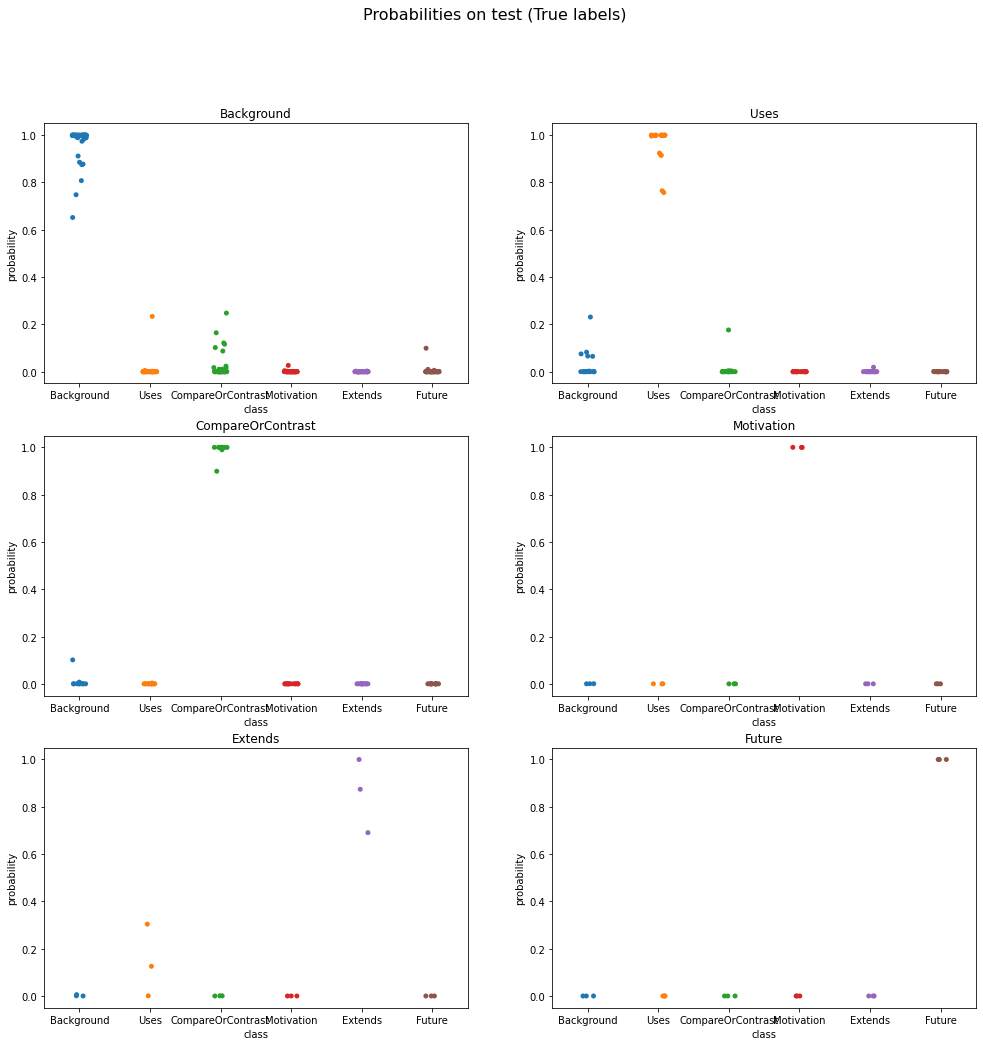

In [13]:
fig, axs = plt.subplots(3, 2, figsize=(16.7, 16.27))
fig.suptitle('Probabilities on test (True labels)', fontsize=16)

axs[0][0].set_title("Background")
df_0 = get_df_for_class(probs_distr_dev, 'Background')
sns.stripplot(ax=axs[0][0], x="class", y="probability", data=df_0)

axs[0][1].set_title("Uses")
df_1 = get_df_for_class(probs_distr_dev, 'Uses')
sns.stripplot(ax=axs[0][1], x="class", y="probability", data=df_1)

axs[1][0].set_title("CompareOrContrast")
df_2 = get_df_for_class(probs_distr_dev, 'CompareOrContrast')
sns.stripplot(ax=axs[1][0], x="class", y="probability", data=df_2)

axs[1][1].set_title("Motivation")
df_3 = get_df_for_class(probs_distr_dev, 'Motivation')
sns.stripplot(ax=axs[1][1], x="class", y="probability", data=df_3)

axs[2][0].set_title("Extends")
df_4 = get_df_for_class(probs_distr_dev, 'Extends')
sns.stripplot(ax=axs[2][0], x="class", y="probability", data=df_4)

axs[2][1].set_title("Future")
df_5 = get_df_for_class(probs_distr_dev, 'Future')
sns.stripplot(ax=axs[2][1], x="class", y="probability", data=df_5)

In [14]:
probs_error_distr = {cls: [] for cls in CLASSES}
for error in errors_dev:
    probs_error_distr[error['intent']].append(error['probabilities'])

<AxesSubplot:title={'center':'Future'}, xlabel='class', ylabel='probability'>

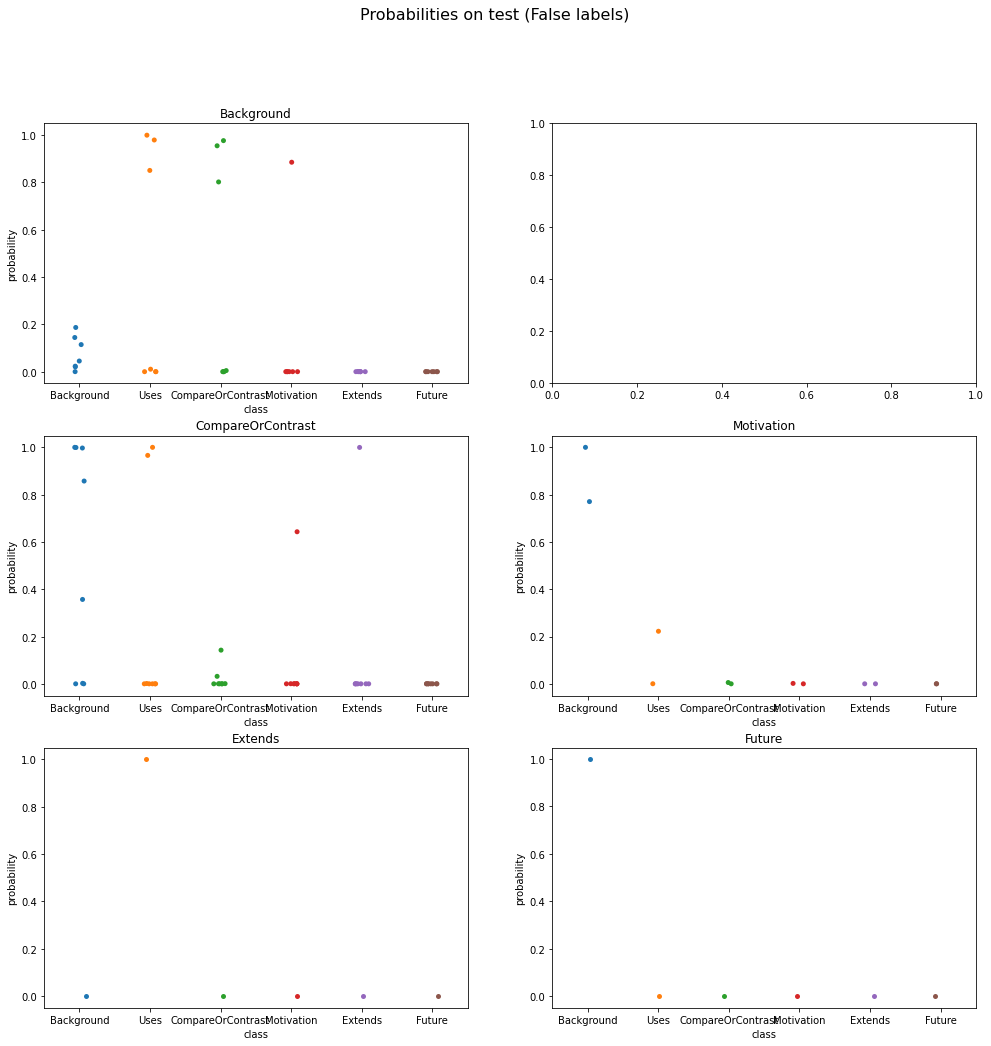

In [15]:
fig, axs = plt.subplots(3, 2, figsize=(16.7, 16.27))
fig.suptitle('Probabilities on test (False labels)', fontsize=16)

axs[0][0].set_title("Background")
df_0 = get_df_for_class(probs_error_distr, 'Background')
sns.stripplot(ax=axs[0][0], x="class", y="probability", data=df_0)

#axs[0][1].set_title("Uses")
#df_1 = get_df_for_class(probs_error_distr, 'Uses')
#sns.stripplot(ax=axs[0][1], x="class", y="probability", data=df_1)

axs[1][0].set_title("CompareOrContrast")
df_2 = get_df_for_class(probs_error_distr, 'CompareOrContrast')
sns.stripplot(ax=axs[1][0], x="class", y="probability", data=df_2)

axs[1][1].set_title("Motivation")
df_3 = get_df_for_class(probs_error_distr, 'Motivation')
sns.stripplot(ax=axs[1][1], x="class", y="probability", data=df_3)

axs[2][0].set_title("Extends")
df_4 = get_df_for_class(probs_error_distr, 'Extends')
sns.stripplot(ax=axs[2][0], x="class", y="probability", data=df_4)

axs[2][1].set_title("Future")
df_5 = get_df_for_class(probs_error_distr, 'Future')
sns.stripplot(ax=axs[2][1], x="class", y="probability", data=df_5)

3.  Patterns distribution

In [16]:
def get_pat_dist():
    pattern_distr_all_data = {cls: np.zeros(112) for cls in CLASSES}
    for _class in CLASSES:
        for item in patterns_distr_test[_class]:
            pattern_distr_all_data[_class] = np.add(pattern_distr_all_data[_class], item)

        for item in patterns_distr_dev[_class]:
            pattern_distr_all_data[_class] = np.add(pattern_distr_all_data[_class], item)

        for item in patterns_distr_train[_class]:
            pattern_distr_all_data[_class] = np.add(pattern_distr_all_data[_class], item)    

    return pattern_distr_all_data

In [17]:
prep_pat_dist = get_pat_dist()

In [18]:
CLASSES

['Background', 'Uses', 'CompareOrContrast', 'Motivation', 'Extends', 'Future']

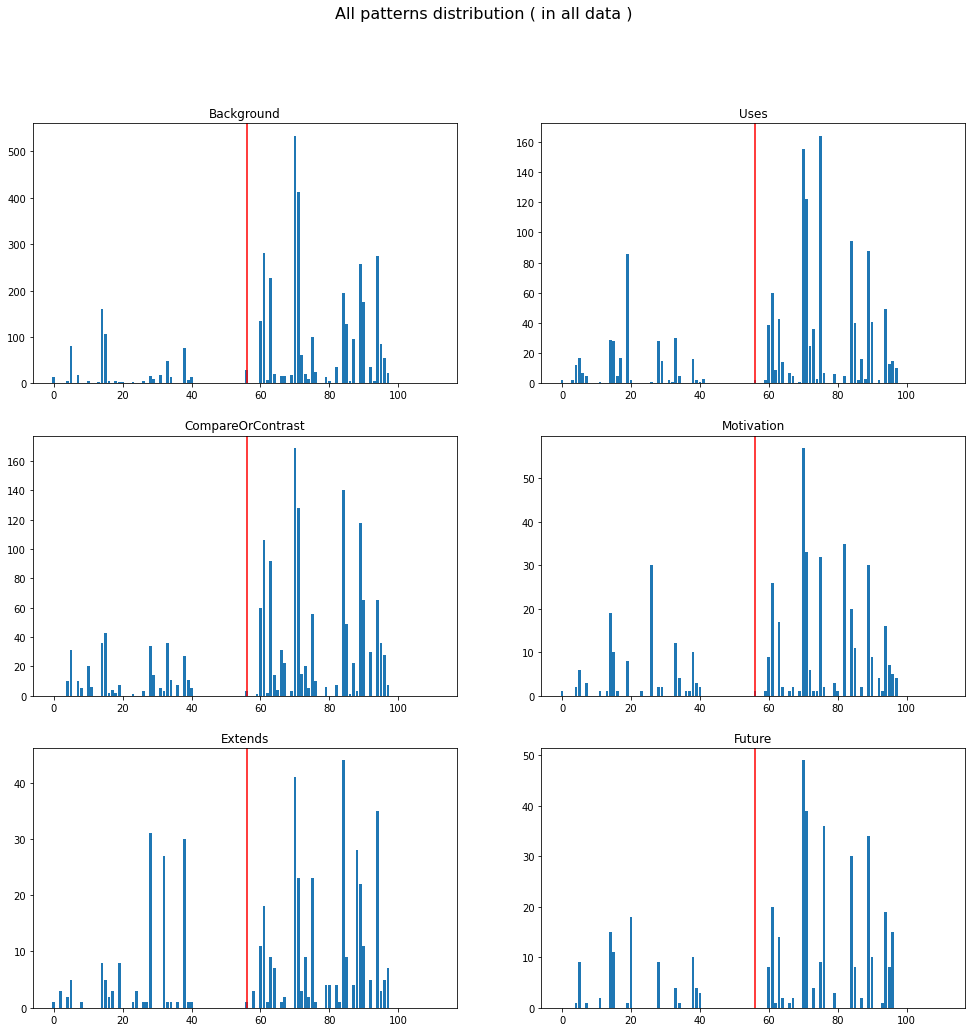

In [19]:
fig, axs = plt.subplots(3, 2, figsize=(16.7, 16.27))
fig.suptitle('All patterns distribution ( in all data )', fontsize=16)

axs[0][0].set_title("Background")
axs[0][0].bar(range(112), prep_pat_dist['Background'])
axs[0][0].axvline(x=56, color='red')

axs[0][1].set_title("Uses")
axs[0][1].bar(range(112), prep_pat_dist['Uses'])
axs[0][1].axvline(x=56, color='red')

axs[1][0].set_title("CompareOrContrast")
axs[1][0].bar(range(112), prep_pat_dist['CompareOrContrast'])
axs[1][0].axvline(x=56, color='red')

axs[1][1].set_title("Motivation")
axs[1][1].bar(range(112), prep_pat_dist['Motivation'])
axs[1][1].axvline(x=56, color='red')

axs[2][0].set_title("Extends")
axs[2][0].bar(range(112), prep_pat_dist['Extends'])
axs[2][0].axvline(x=56, color='red')

axs[2][1].set_title("Future")
axs[2][1].bar(range(112), prep_pat_dist['Future'])
axs[2][1].axvline(x=56, color='red')

<BarContainer object of 56 artists>

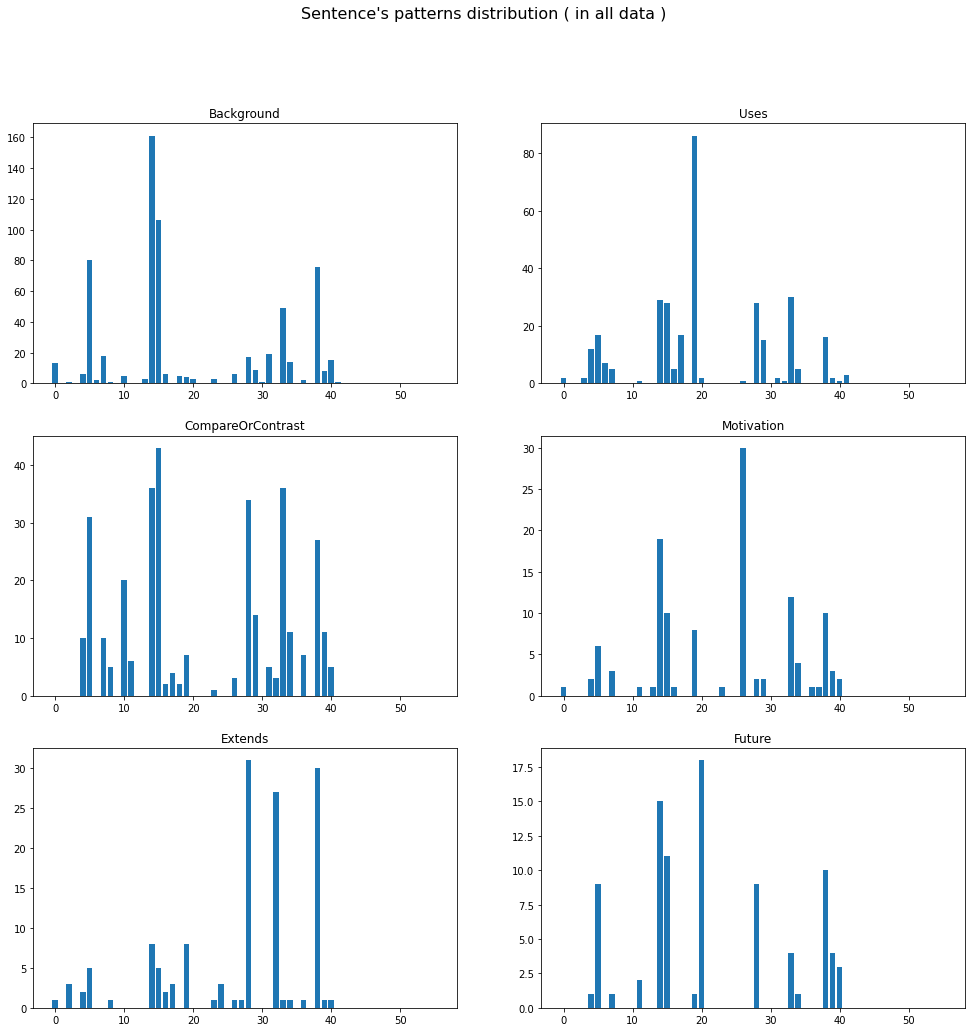

In [20]:
fig, axs = plt.subplots(3, 2, figsize=(16.7, 16.27))
fig.suptitle("Sentence's patterns distribution ( in all data )", fontsize=16)

axs[0][0].set_title("Background")
axs[0][0].bar(range(56), prep_pat_dist['Background'][:56])

axs[0][1].set_title("Uses")
axs[0][1].bar(range(56), prep_pat_dist['Uses'][:56])

axs[1][0].set_title("CompareOrContrast")
axs[1][0].bar(range(56), prep_pat_dist['CompareOrContrast'][:56])

axs[1][1].set_title("Motivation")
axs[1][1].bar(range(56), prep_pat_dist['Motivation'][:56])

axs[2][0].set_title("Extends")
axs[2][0].bar(range(56), prep_pat_dist['Extends'][:56])

axs[2][1].set_title("Future")
axs[2][1].bar(range(56), prep_pat_dist['Future'][:56])

In [21]:
class_cnt = {
    'Background': 997,
    'Uses': 364,
    'CompareOrContrast': 351,
    'Motivation': 88,
    'Extends': 72,
    'Future': 69   }

<BarContainer object of 56 artists>

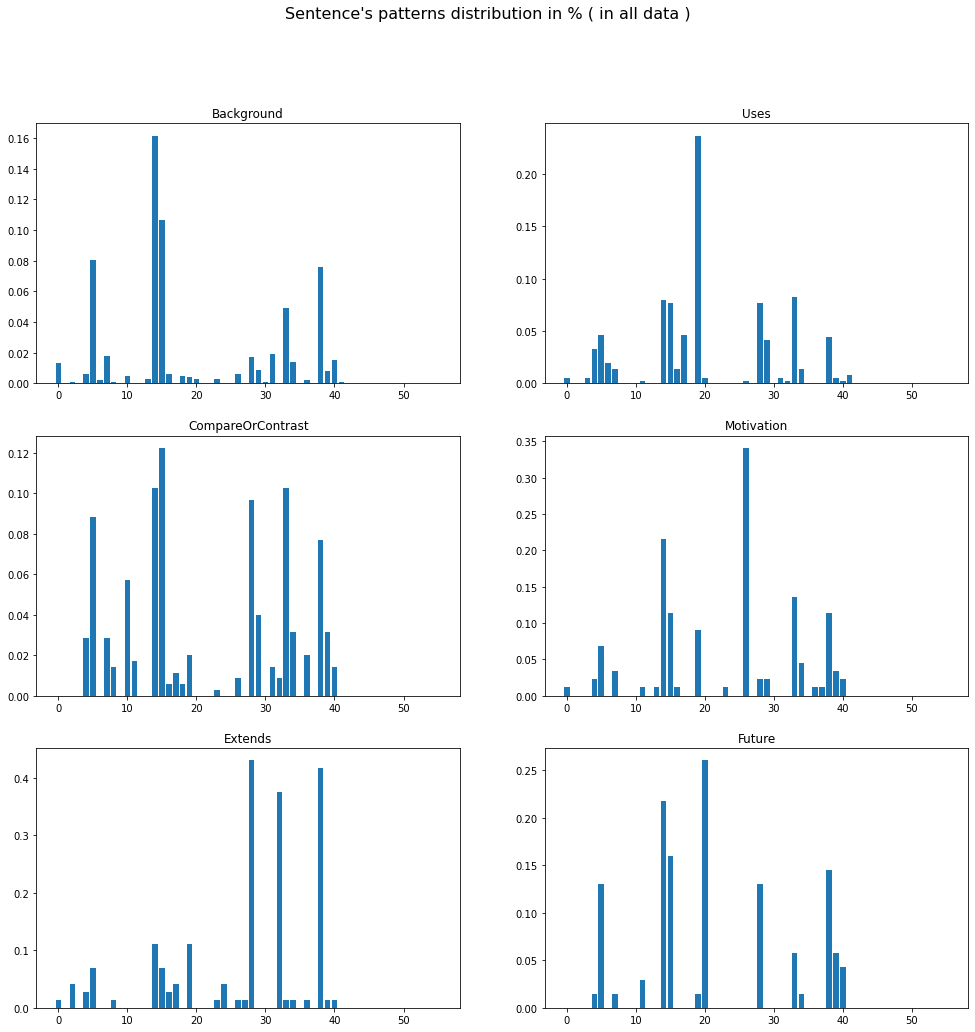

In [22]:
fig, axs = plt.subplots(3, 2, figsize=(16.7, 16.27))
fig.suptitle("Sentence's patterns distribution in % ( in all data )", fontsize=16)

axs[0][0].set_title("Background")
axs[0][0].bar(range(56), prep_pat_dist['Background'][:56]/class_cnt['Background'])

axs[0][1].set_title("Uses")
axs[0][1].bar(range(56), prep_pat_dist['Uses'][:56]/class_cnt['Uses'])

axs[1][0].set_title("CompareOrContrast")
axs[1][0].bar(range(56), prep_pat_dist['CompareOrContrast'][:56]/class_cnt['CompareOrContrast'])

axs[1][1].set_title("Motivation")
axs[1][1].bar(range(56), prep_pat_dist['Motivation'][:56]/class_cnt['Motivation'])

axs[2][0].set_title("Extends")
axs[2][0].bar(range(56), prep_pat_dist['Extends'][:56]/class_cnt['Extends'])

axs[2][1].set_title("Future")
axs[2][1].bar(range(56), prep_pat_dist['Future'][:56]/class_cnt['Future'])

<BarContainer object of 56 artists>

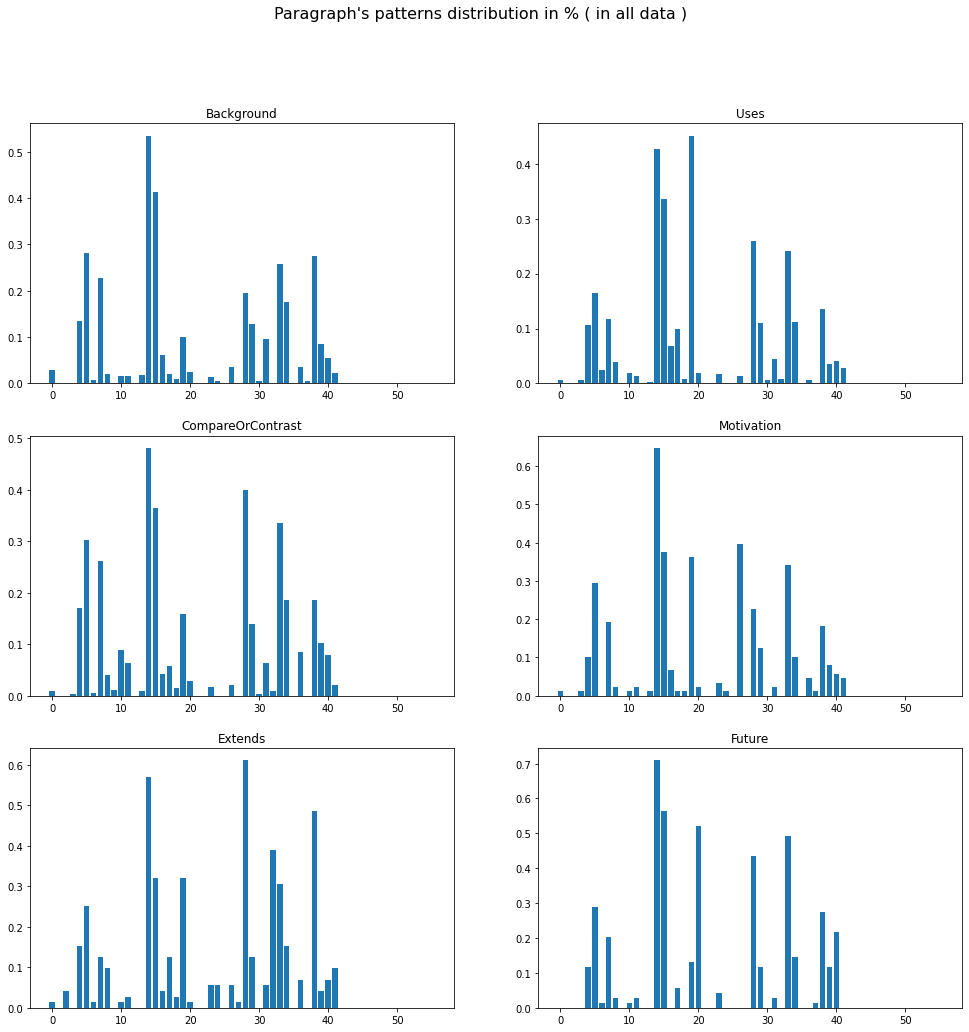

In [23]:
fig, axs = plt.subplots(3, 2, figsize=(16.7, 16.27))
fig.suptitle("Paragraph's patterns distribution in % ( in all data )", fontsize=16)

axs[0][0].set_title("Background")
axs[0][0].bar(range(56), prep_pat_dist['Background'][56:]/class_cnt['Background'])

axs[0][1].set_title("Uses")
axs[0][1].bar(range(56), prep_pat_dist['Uses'][56:]/class_cnt['Uses'])

axs[1][0].set_title("CompareOrContrast")
axs[1][0].bar(range(56), prep_pat_dist['CompareOrContrast'][56:]/class_cnt['CompareOrContrast'])

axs[1][1].set_title("Motivation")
axs[1][1].bar(range(56), prep_pat_dist['Motivation'][56:]/class_cnt['Motivation'])

axs[2][0].set_title("Extends")
axs[2][0].bar(range(56), prep_pat_dist['Extends'][56:]/class_cnt['Extends'])

axs[2][1].set_title("Future")
axs[2][1].bar(range(56), prep_pat_dist['Future'][56:]/class_cnt['Future'])

4.  Models on patterns

In [237]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import cross_val_score
from lightgbm import LGBMClassifier

In [187]:
def create_data():
    X_train, X_test, X_dev = [], [], []
    y_train, y_test, y_dev = [], [], []
    train_ids, test_ids, dev_ids = [], [], []
    
    with jsonlines.open(FILE_TEST_TRUE, 'r') as reader:
        for item in reader:
            _x, _y, _ = compute_all_patterns_features(item)
            test_ids.append(item['citation_id'])
            X_test.append(_x)
            y_test.append(_y)
    
    with jsonlines.open(FILE_DEV_TRUE, 'r') as reader:
        for item in reader:
            _x, _y, _ = compute_all_patterns_features(item)
            dev_ids.append(item['citation_id'])
            X_dev.append(_x)
            y_dev.append(_y)
    
    with jsonlines.open(FILE_TRAIN_TRUE, 'r') as reader:
        for item in reader:
            _x, _y, _ = compute_all_patterns_features(item)
            train_ids.append(item['citation_id'])
            X_train.append(_x)
            y_train.append(_y)
    
    return np.array(X_train), np.array(y_train), train_ids, np.array(X_dev), np.array(y_dev), dev_ids, \
            np.array(X_test), np.array(y_test), test_ids

In [188]:
X_train, y_train, train_ids, X_dev, y_dev, dev_ids, X_test, y_test, test_ids = create_data()

In [223]:
def get_pred_result(true_file, pred_file, clf, pred_data, ids_dict):
    result = []
    
    # true values
    true = dict()
    with jsonlines.open(true_file) as reader:
        for obj in reader:
            true[obj['citation_id']] = obj
    
    # pred values
    with jsonlines.open(pred_file) as reader:
        for obj in reader:
            cur_item = true[obj['citation_id']]
            cur_item['prediction'] = obj['prediction']
            cur_item['probabilities'] = obj['probabilities']
            pred_item = [pred_data[ids_dict.index(obj['citation_id'])]]
            cur_item['clf_prediction'] = CLASSES[clf.predict(pred_item)[0]]
            cur_item['clf_probabilities'] = clf.predict_proba(pred_item)
            result.append(cur_item)
    
    return result

In [265]:
def get_pred_new_result(true_file, pred_file, clf, pred_data, ids_dict):
    result = []
    
    # true values
    true = dict()
    with jsonlines.open(true_file) as reader:
        for obj in reader:
            true[obj['citation_id']] = obj
    
    # pred values
    with jsonlines.open(pred_file) as reader:
        for obj in reader:
            cur_item = true[obj['citation_id']]
            cur_item['prediction'] = obj['prediction']
            cur_item['probabilities'] = obj['probabilities']
            pred_item = [pred_data[ids_dict.index(obj['citation_id'])]]
            cur_item['clf_prediction'] = clf.predict(pred_item)[0]
            cur_item['clf_probabilities'] = clf.predict_proba(pred_item)
            result.append(cur_item)
    
    return result

4.1  LogReg

In [240]:
clf = LogisticRegression(multi_class='multinomial')
scores = cross_val_score(clf, X_train, y_train, scoring='f1_macro', cv=5)
scores.mean()

0.48057629688116066

In [241]:
clf = LogisticRegression(multi_class='multinomial').fit(X_train, y_train)

In [243]:
dev_pred_result_lr = get_pred_result(FILE_DEV_TRUE, FILE_DEV_PRED, clf, X_dev, dev_ids)

In [244]:
for item in dev_pred_result_lr:
    print(f"True class      = {item['intent']}")
    print(f"Bert prediction = {item['prediction']}")
    print(f"Clf  prediction = {item['clf_prediction']}")
    print(f"Bert probabilities = {item['probabilities']}")
    print(f"Clf  probabilities = {item['clf_probabilities']}\n")

True class      = Background
Bert prediction = Background
Clf  prediction = Background
Bert probabilities = [0.9999761581420898, 1.8360765352554154e-07, 7.936537826935819e-07, 2.2803038518759422e-05, 5.868953767418361e-09, 3.4610616594932253e-09]
Clf  probabilities = [[0.69041048 0.13475372 0.13280373 0.01572296 0.01324674 0.01306238]]

True class      = CompareOrContrast
Bert prediction = CompareOrContrast
Clf  prediction = Background
Bert probabilities = [7.943081072880886e-07, 1.5501325917322006e-11, 0.9999991655349731, 9.701416336937996e-10, 1.8566142699437795e-15, 3.850743576544642e-14]
Clf  probabilities = [[0.46722812 0.11543427 0.30355426 0.0639485  0.02117405 0.02866079]]

True class      = Background
Bert prediction = Background
Clf  prediction = Background
Bert probabilities = [0.9997257590293884, 3.458375985587736e-08, 0.0002653480914887041, 8.826144949125592e-06, 5.910075540072057e-09, 6.576298616778331e-09]
Clf  probabilities = [[0.60734161 0.06842968 0.22095304 0.0335675

4.2 Lightgbm

In [246]:
clf = LGBMClassifier()
scores = cross_val_score(clf, X_train, y_train, scoring='f1_macro', cv=5)
scores.mean()

0.5392998088369465

In [248]:
clf = LGBMClassifier().fit(X_train, y_train)

In [249]:
dev_pred_result_lgb = get_pred_result(FILE_DEV_TRUE, FILE_DEV_PRED, clf, X_dev, dev_ids)

In [251]:
for item in dev_pred_result_lgb:
    if not (item['intent'] == item['prediction'] == item['clf_prediction']):
        print(f"True class      = {item['intent']}")
        print(f"Bert prediction = {item['prediction']}")
        print(f"Clf  prediction = {item['clf_prediction']}")
        print(f"Bert probabilities = {item['probabilities']}")
        print(f"Clf  probabilities = {item['clf_probabilities']}\n")

True class      = CompareOrContrast
Bert prediction = CompareOrContrast
Clf  prediction = Background
Bert probabilities = [7.943081072880886e-07, 1.5501325917322006e-11, 0.9999991655349731, 9.701416336937996e-10, 1.8566142699437795e-15, 3.850743576544642e-14]
Clf  probabilities = [[0.81109348 0.05686018 0.09012563 0.02129207 0.01389656 0.00673208]]

True class      = Future
Bert prediction = Background
Clf  prediction = Background
Bert probabilities = [0.9968156218528748, 0.0014911321923136711, 5.651293122355128e-06, 0.0003448179049883038, 0.0013291158247739077, 1.3665680853591766e-05]
Clf  probabilities = [[0.65334044 0.14792712 0.09153666 0.02417836 0.01777497 0.06524244]]

True class      = Background
Bert prediction = CompareOrContrast
Clf  prediction = Background
Bert probabilities = [0.18689027428627014, 0.010484028607606888, 0.8021636009216309, 2.579911893008102e-07, 0.00043901248136535287, 2.284014772158116e-05]
Clf  probabilities = [[7.83088144e-01 3.22722157e-02 1.77157834e-0

In [184]:
y_dev

array([0, 2, 0, 0, 0, 0, 5, 0, 0, 0, 0, 1, 2, 3, 3, 0, 0, 0, 1, 2, 0, 0,
       0, 0, 0, 1, 1, 2, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0,
       2, 2, 1, 1, 0, 0, 1, 2, 2, 0, 0, 0, 4, 2, 0, 2, 4, 2, 0, 1, 0, 0,
       3, 0, 1, 0, 0, 2, 0, 4, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 2, 0, 5,
       2, 4, 0, 2, 0, 2, 0, 0, 0, 1, 3, 2, 2, 1, 0, 2, 3, 0, 5, 0, 5, 1,
       0, 0, 0, 2])

In [189]:
probs_distr_dev

{'Background': [[0.9999761581420898,
   1.8360765352554154e-07,
   7.936537826935819e-07,
   2.2803038518759422e-05,
   5.868953767418361e-09,
   3.4610616594932253e-09],
  [0.9997257590293884,
   3.458375985587736e-08,
   0.0002653480914887041,
   8.826144949125592e-06,
   5.910075540072057e-09,
   6.576298616778331e-09],
  [0.9949464201927185,
   0.005020191427320242,
   3.912264787686581e-07,
   1.1710676517395768e-05,
   2.0347535610198975e-05,
   9.242583587365516e-07],
  [0.9999788999557495,
   2.564424050888192e-08,
   1.699063432170078e-05,
   4.027263457828667e-06,
   1.4563485528640285e-08,
   6.262088181330228e-09],
  [0.9999638795852661,
   1.5759386542413267e-06,
   3.3982203603954986e-05,
   6.405262524822319e-07,
   7.083450270783942e-09,
   4.333265302136624e-09],
  [0.9999953508377075,
   1.597769028194307e-07,
   2.755338300630683e-06,
   1.352943058918754e-06,
   5.075336275695008e-07,
   4.206667014727827e-09],
  [0.6518540978431702,
   0.23366354405879974,
   0.101

In [255]:
y_train_new = y_train == 0
y_dev_new = y_dev == 0
y_test_new = y_test == 0

In [262]:
clf_new = LGBMClassifier()
scores = cross_val_score(clf_new, X_train, y_train_new, scoring='f1', cv=5)
scores.mean()

0.7485900984459736

In [266]:
clf_new = LGBMClassifier().fit(X_train, y_train_new)

In [267]:
dev_new_pred_result_lgb = get_pred_new_result(FILE_DEV_TRUE, FILE_DEV_PRED, clf_new, X_dev, dev_ids)

False labels

In [269]:
for item in dev_new_pred_result_lgb:
    if not (item['intent'] == item['prediction']):
        print(f"True class      = {item['intent']}")
        print(f"Bert prediction = {item['prediction']}")
        print(f"Clf  prediction = {item['clf_prediction']}")
        print(f"Bert probabilities = {item['probabilities']}")
        print(f"Clf  probabilities = {item['clf_probabilities']}\n")

True class      = Future
Bert prediction = Background
Clf  prediction = False
Bert probabilities = [0.9968156218528748, 0.0014911321923136711, 5.651293122355128e-06, 0.0003448179049883038, 0.0013291158247739077, 1.3665680853591766e-05]
Clf  probabilities = [[0.61599574 0.38400426]]

True class      = Background
Bert prediction = CompareOrContrast
Clf  prediction = True
Bert probabilities = [0.18689027428627014, 0.010484028607606888, 0.8021636009216309, 2.579911893008102e-07, 0.00043901248136535287, 2.284014772158116e-05]
Clf  probabilities = [[0.1548253 0.8451747]]

True class      = Background
Bert prediction = Uses
Clf  prediction = True
Bert probabilities = [0.020412202924489975, 0.9795134663581848, 5.5912305896299586e-09, 6.120437205936469e-07, 7.378187729045749e-05, 1.5125694474704687e-08]
Clf  probabilities = [[0.21415133 0.78584867]]

True class      = CompareOrContrast
Bert prediction = Background
Clf  prediction = False
Bert probabilities = [0.8574911952018738, 1.6387290088459

True labels

In [271]:
for item in dev_new_pred_result_lgb:
    if item['intent'] == item['prediction']:
        print(f"True class      = {item['intent']}")
        print(f"Bert prediction = {item['prediction']}")
        print(f"Clf  prediction = {item['clf_prediction']}")
        print(f"Bert probabilities = {item['probabilities']}")
        print(f"Clf  probabilities = {item['clf_probabilities']}\n")

True class      = Background
Bert prediction = Background
Clf  prediction = True
Bert probabilities = [0.9999761581420898, 1.8360765352554154e-07, 7.936537826935819e-07, 2.2803038518759422e-05, 5.868953767418361e-09, 3.4610616594932253e-09]
Clf  probabilities = [[0.12846045 0.87153955]]

True class      = CompareOrContrast
Bert prediction = CompareOrContrast
Clf  prediction = True
Bert probabilities = [7.943081072880886e-07, 1.5501325917322006e-11, 0.9999991655349731, 9.701416336937996e-10, 1.8566142699437795e-15, 3.850743576544642e-14]
Clf  probabilities = [[0.32359567 0.67640433]]

True class      = Background
Bert prediction = Background
Clf  prediction = True
Bert probabilities = [0.9997257590293884, 3.458375985587736e-08, 0.0002653480914887041, 8.826144949125592e-06, 5.910075540072057e-09, 6.576298616778331e-09]
Clf  probabilities = [[0.2173238 0.7826762]]

True class      = Background
Bert prediction = Background
Clf  prediction = True
Bert probabilities = [0.9949464201927185, 0.